## Imports

In [2]:
!pip install tensorflow-addons

In [3]:
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # read and manipulate local files

import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score as f1_score_report


import random

from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow.keras as ks
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa # elastic_deformation

from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Dense, BatchNormalization, Concatenate, GlobalAveragePooling2D

# hide wornings
import warnings
warnings.filterwarnings('ignore')

################################################################################################
# SETTING F1 SCORE
from tensorflow_addons.metrics import F1Score
f1_score = F1Score(num_classes=4, average='macro')

## Setting the paths

In [4]:
model_name = 'parallel_vit_dropout_changed'#'Xception'#'DenseNet121'#    'InceptionV3'##  'MobileNet', 'Xception', ensemble2, ensemble3, 'parallel_vit'

################################################################################################

## SEETING THE PATHS
PATH_TO_CODE =''
# PATH_TO_CODE ='/content/drive/MyDrive/TRIAL_v1/classification'
sys.path.append(PATH_TO_CODE)
# DATASET_PATH = r'/content/drive/MyDrive/TRIAL_v1/classification/data44_resized_splited'
DATASET_PATH = r'data44_resized_splited'
DATASET_PATH_TRAIN = os.path.join(DATASET_PATH, 'train')
DATASET_PATH_TEST = os.path.join(DATASET_PATH, 'test')


PATH_TO_SAVE_RESULT = os.path.join(PATH_TO_CODE, 'saved_outputs_all_augment', model_name)
PATH_BEST_SAVE_WEIGHT = os.path.join(PATH_TO_SAVE_RESULT,model_name+'_saved_weights')
PATH_TO_SAVE_MODEL = os.path.join(PATH_TO_SAVE_RESULT, 'saved_models')
PATH_SAVE_HISTORY = os.path.join(PATH_TO_SAVE_RESULT,model_name+'_training_history.csv')
PATH_SAVE_TIME = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_training_time.csv')


if not os.path.exists(PATH_TO_SAVE_RESULT):
    # If it does not exist, create it
    os.makedirs(PATH_TO_SAVE_RESULT)

if not os.path.exists(PATH_BEST_SAVE_WEIGHT):
    # If it does not exist, create it
    os.makedirs(PATH_BEST_SAVE_WEIGHT)
################################################################################################


IMG_HEIGHT = 200
IMG_WIDTH = 200
ORIGINAL_IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
COLOR_CHANNEL = 3

RESIZE_SHAPE = (128, 128)
MODEL_INPUT_SIZE = (RESIZE_SHAPE[0], RESIZE_SHAPE[1], COLOR_CHANNEL)

VALIDATION_SPLIT= 0.3
NUM_CLASSES = 4

BATCH_SIZE = 64
EPOCHS = 150

################################################################################################
AUGMENT = True
AUGMENT_TYPE = 'all' #'all'## basic, advanced,
################################################################################################

SAVE_RESULTS = True
SHOW_RESULTS = True

################################################################################################
# Setting the seed
SEED  = 123
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

################################################################################################
# Checkpoint parameters
SCORE_TO_MONITOR = 'val_f1_score' # Score that checkpoints monitor during training
SCORE_OBJECTIVE  = 'max'          # 'max' or 'min', specifies whether the objective is to maximize the score or minimize it.



PATIENCE_EARLY_STOP = 12 # With no improvement in Loss, will stop training

# # Checkpoint parameters
REDUCTION_FACTOR = 0.5            # Factor which lr will be reduced with at plateau
PATIENCE_LR_REDUCE=3      # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN_EPOCHS  = 2              # How many epochs to wait after learning rate reduction before it can be reduced again
MIN_LR = 1e-9
INITIAL_LR = 0.0001 # with 0.001 got 99 percent

In [5]:
print("DATASET_PATH", DATASET_PATH)
print("DATASET_PATH_TRAIN", DATASET_PATH_TRAIN)
print("DATASET_PATH_TEST", DATASET_PATH_TEST)

print("PATH_SAVE_TIME ", PATH_SAVE_TIME )
print("PATH_SAVE_HISTORY", PATH_SAVE_HISTORY)
print("PATH_TO_SAVE_RESULT",PATH_TO_SAVE_RESULT)
print("PATH_BEST_SAVE_WEIGHT", PATH_BEST_SAVE_WEIGHT)
print("PATH_TO_SAVE_MODEL", PATH_TO_SAVE_MODEL)

DATASET_PATH data44_resized_splited
DATASET_PATH_TRAIN data44_resized_splited\train
DATASET_PATH_TEST data44_resized_splited\test
PATH_SAVE_TIME  saved_outputs_all_augment\parallel_vit_dropout_changed\parallel_vit_dropout_changed_training_time.csv
PATH_SAVE_HISTORY saved_outputs_all_augment\parallel_vit_dropout_changed\parallel_vit_dropout_changed_training_history.csv
PATH_TO_SAVE_RESULT saved_outputs_all_augment\parallel_vit_dropout_changed
PATH_BEST_SAVE_WEIGHT saved_outputs_all_augment\parallel_vit_dropout_changed\parallel_vit_dropout_changed_saved_weights
PATH_TO_SAVE_MODEL saved_outputs_all_augment\parallel_vit_dropout_changed\saved_models


## Using GPU

In [6]:
# Check if GPU is available
print("GPU Available: ", tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
Num GPUs Available:  2


## Image Data Augmentation

### ElasticTransformation

In [7]:
# Define an augmentation pipeline
# Alpha parameter controls the intensity of the deformation
# Sigma controls the smoothness of the deformation field.
aug = iaa.Sequential([
    iaa.ElasticTransformation(alpha=10, sigma=5)  # Apply elastic transformations , sigma=1
])

def elastic_deformation(image):
    image_aug = aug(image=image)
    return image_aug

In [8]:
# Defining a function for creating the generators with given augmentation type
def create_generators(dataset_path_train=DATASET_PATH_TRAIN,
                      dataset_path_test=DATASET_PATH_TEST,
                      valid_ratio=VALIDATION_SPLIT,
                      augment= False,
                      augment_type='basic'):

    # If augmentation is True, apply data augmentation. Otherwise, only rescale.
    if augment:
        if augment_type == 'all':
            datagen = ImageDataGenerator(
                rescale=1./255, # Normalize images
                validation_split=valid_ratio,  # Split ratio for validation set

                # Geometric Transformations
                rotation_range=10,  # degrees
                width_shift_range=0.2,  # fraction of total width
                height_shift_range=0.2,  # fraction of total height
                shear_range=0.2,  # shear angle in counter-clockwise direction as radians
                zoom_range=0.2,  # zoom range for random zoom
                horizontal_flip=True,  # randomly flip images horizontally
                # vertical_flip=True,  # randomly flip images vertically

                # Pixel-Level Transformations
                brightness_range=[0.8, 1.1],  # range for picking a brightness shift value
                channel_shift_range=0.2,  # range for random channel shifts

                # # Advanced functions
                # preprocessing_function=elastic_deformation
            )
        elif augment_type == 'basic':
            datagen = ImageDataGenerator(
                rescale=1./255, # Normalize images
                validation_split=valid_ratio,  # Split ratio for validation set

                # Geometric Transformations
                # rotation_range=10,  # degrees
                zoom_range=0.2,  # zoom range for random zoom
                # vertical_flip=True,  # randomly flip images vertically
                horizontal_flip=True,  # randomly flip images horizontally
            )
    else:
        # No augmentation
        datagen = ImageDataGenerator(
            validation_split=valid_ratio,  # Split ratio for validation set
            rescale=1./255, # Normalize images
        )

    # Create training generator
    train_generator = datagen.flow_from_directory(
        dataset_path_train,
        batch_size=BATCH_SIZE,
        seed = SEED,
        class_mode="categorical",  # Use "categorical" for multi-class classification
        target_size=RESIZE_SHAPE,  # Adjust target size based on your model requirements
        shuffle = True,
        color_mode = 'rgb',
        subset='training'  # Specify subset as 'training'
    )

    # Create validation generator
    valid_generator = datagen.flow_from_directory(
        dataset_path_train,
        batch_size=BATCH_SIZE,
        seed = SEED,
        class_mode="categorical",  # Use "categorical" for multi-class classification
        target_size=RESIZE_SHAPE,  # Adjust target size based on your model requirements
        shuffle = True,
        color_mode = 'rgb',
        subset='validation'  # Specify subset as 'validation'
    )

    # For the test set, assuming no augmentation, just rescaling
    test_datagen = ImageDataGenerator(
                rescale=1./255# Normalize images
    )
    test_generator = test_datagen.flow_from_directory(
        dataset_path_test,
        class_mode="categorical",  # Use "categorical" for multi-class classification
        target_size=RESIZE_SHAPE,  # Adjust target size based on your model requirements
        seed = SEED,
        shuffle = False,
        color_mode = 'rgb',
        batch_size=BATCH_SIZE)

    return train_generator, valid_generator, test_generator

In [9]:
# Creating the generators using functions
train_generator, valid_generator, test_generator = create_generators(dataset_path_train=DATASET_PATH_TRAIN,
                                                                     dataset_path_test = DATASET_PATH_TEST,
                                                                     augment=AUGMENT,
                                                                     augment_type = AUGMENT_TYPE,
                                                                     valid_ratio = VALIDATION_SPLIT)

Found 3324 images belonging to 4 classes.
Found 1421 images belonging to 4 classes.
Found 1187 images belonging to 4 classes.


## Visualization

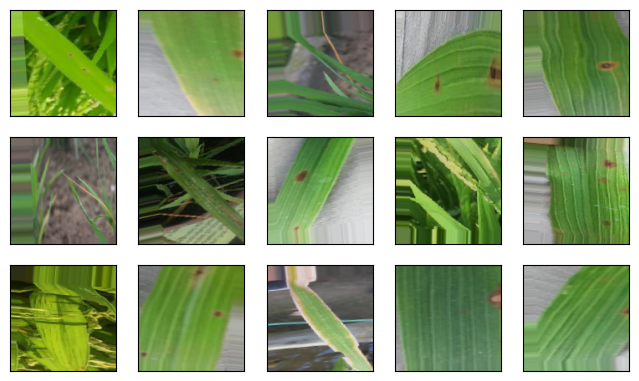

In [10]:
def plot_images(images, labels, classes=None):
    plt.figure(figsize=(8, 8))
    for i in range(15):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)

        # If class labels are provided, add them to the subplot
        if classes is not None:
            label = classes[np.argmax(labels[i])]
            plt.xlabel(label)
    plt.show()


train_images, train_labels = next(train_generator)  # Fetch a batch of images and labels


plot_images(train_images, train_labels)

## Essential functions (training)

In [12]:
def fit_and_save_best_model_vit(model_name, model, epochs=EPOCHS):
    ##########################################################################################################

    # Criteria for early stopping
    EarlyStop_callback = EarlyStopping(min_delta=0.0001, patience=PATIENCE_EARLY_STOP, restore_best_weights=True)
    ##########################################################################################################

    # saved_best_weights = 'best_'+model_name+'_weights'
    # PATH_BEST_WEIGHT_SAVE = os.path.join(PATH_BEST_SAVE_WEIGHT, saved_best_weights)
    # Set up a model checkpoint to save the best model during training
    best_weight_callback= ModelCheckpoint(filepath=PATH_BEST_SAVE_WEIGHT,
                                          monitor=SCORE_TO_MONITOR,
                                          save_best_only=True,
                                          mode=SCORE_OBJECTIVE,
                                          verbose=1,
                                          save_weights_only=True )

    ##########################################################################################################
    # # Setup the ReduceLROnPlateau callback
    reduce_LR = ReduceLROnPlateau(
        factor=REDUCTION_FACTOR,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=PATIENCE_LR_REDUCE,      # Number of epochs with no improvement after which learning rate will be reduced.
        verbose=1,       # int. 0: quiet, 1: update messages.
        min_lr=MIN_LR,   # Lower bound on the learning rate.
        cooldown = COOLDOWN_EPOCHS
    )

    my_callbacks = [best_weight_callback , reduce_LR , EarlyStop_callback]
    ##########################################################################################################
    start_time = time.time()
    # Fitting the model
    train_history = model.fit(
        train_generator,
        epochs= epochs,
        batch_size=BATCH_SIZE,
        validation_data=valid_generator,
        callbacks=my_callbacks,
    )
    total_time = time.time() -start_time
    return  PATH_BEST_SAVE_WEIGHT, train_history , total_time#model_saving_path,

## Essential functions (saving result)

In [13]:
def plot_training_history(training_history_object, list_of_metrics=None):
    """
    Input:
        training_history_object:: Object returned by model.fit() function in keras
        list_of_metrics        :: A list of metrics to be plotted. Use if you only
                                  want to plot a subset of the total set of metrics
                                  in the training history object. By Default it will
                                  plot all of them in individual subplots.
    """
    history_dict = training_history_object.history

    ###################ADDDED NEW################################################
    # Remove 'lr' and 'val_lr' keys from history_dict if they exist
    history_dict.pop('lr', None)
    history_dict.pop('val_lr', None)
    #############################################################################

    if list_of_metrics is None:
        list_of_metrics = [key for key in list(history_dict.keys()) if 'val_' not in key]
    trainHistDF = pd.DataFrame(history_dict)
    # trainHistDF.head()
    train_keys = list_of_metrics
    valid_keys = ['val_' + key for key in train_keys]
    nr_plots = len(train_keys)
    fig, ax = plt.subplots(1,nr_plots,figsize=(5*nr_plots,4))
    for i in range(len(train_keys)):
        ax[i].plot(np.array(trainHistDF[train_keys[i]]), label='Training')
        ax[i].plot(np.array(trainHistDF[valid_keys[i]]), label='Validation')
        ax[i].set_xlabel('Epoch')
        ax[i].set_title(train_keys[i])
        ax[i].grid('on')
        ax[i].legend()
    fig.tight_layout
    # plt.show()

    if SAVE_RESULTS:
        # Save the plot to a PDF
        pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_training_history.pdf")
        with PdfPages(pdf_filename) as pdf:
            pdf.savefig(fig)
            if SHOW_RESULTS:
                plt.show()
            else:
                plt.close()

In [14]:
def show_save_confusion_matrix(predicted_labels, target_labels):
    cm = confusion_matrix(target_labels, predicted_labels)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='g',  cmap='Greens')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    # plt.show()

    # Save the plot to a PDF
    if SAVE_RESULTS:
        pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_confusion_matrix.pdf")
        with PdfPages(pdf_filename) as pdf:
            pdf.savefig()  # saves the current figure into a pdf page
            # plt.close()
            if SHOW_RESULTS:
                plt.show()
            else:
                plt.close()

In [15]:
def calculate_TF_TP_FP_FN(true_labels_y_test, predicted_labels):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels_y_test, predicted_labels)

    class_to_performance_data = {}
    # Calculate TP, FP, TN, FN for each class
    num_classes = cm.shape[0]
    for cls in range(num_classes):
        TP = cm[cls, cls]
        FP = cm[:, cls].sum() - TP
        FN = cm[cls, :].sum() - TP
        TN = cm.sum() - (FP + FN + TP)

        # Calculate support for each class
        support = TP + FN

        class_to_performance_data[cls] = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN, 'Support': support}
    return class_to_performance_data


def calculate_metrics(class_to_performance_data, accuracy, SHOW_RESULTS=True, SAVE_RESULTS=True):
    metrics_summary = {
        'overall':{},
        'Macro': {},
        'Weighted': {}
    }

    metrics_summary[ 'overall']= {'accuracy': accuracy}

    # Lists to store metric values for macro averaging
    precision_list, recall_list, f1_score_list = [], [], []
    fpr_list, fnr_list, fdr_list, npv_list = [], [], [], []

    # Variables for weighted sum of metrics
    weighted_precision, weighted_recall, weighted_f1 = 0, 0, 0
    weighted_fpr, weighted_fnr, weighted_fdr, weighted_npv = 0, 0, 0, 0
    total_support = 0

    # Calculate metrics for each class
    for class_id, metrics in class_to_performance_data.items():
        tp = metrics['TP']
        fp = metrics['FP']
        tn = metrics['TN']
        fn = metrics['FN']
        support = metrics['Support']

        # Basic evaluation metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Additional evaluation metrics
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
        fdr = fp / (fp + tp) if (fp + tp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0

        # Append to lists for macro averaging
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        fpr_list.append(fpr)
        fnr_list.append(fnr)
        fdr_list.append(fdr)
        npv_list.append(npv)

        # Weighted sum of metrics
        weighted_precision += precision * support
        weighted_recall += recall * support
        weighted_f1 += f1_score * support
        weighted_fpr += fpr * support
        weighted_fnr += fnr * support
        weighted_fdr += fdr * support
        weighted_npv += npv * support
        total_support += support

    # Calculate macro averages and round to 5 decimal places
    metrics_summary['Macro']['Precision'] = round(sum(precision_list) / len(precision_list), 5)
    metrics_summary['Macro']['Recall'] = round(sum(recall_list) / len(recall_list), 5)
    metrics_summary['Macro']['F1-Score'] = round(sum(f1_score_list) / len(f1_score_list), 5)
    metrics_summary['Macro']['FPR'] = round(sum(fpr_list) / len(fpr_list), 5)
    metrics_summary['Macro']['FNR'] = round(sum(fnr_list) / len(fnr_list), 5)
    metrics_summary['Macro']['FDR'] = round(sum(fdr_list) / len(fdr_list), 5)
    metrics_summary['Macro']['NPV'] = round(sum(npv_list) / len(npv_list), 5)

    # Calculate weighted averages and round to 5 decimal places
    if total_support > 0:
        metrics_summary['Weighted']['Precision'] = round(weighted_precision / total_support, 5)
        metrics_summary['Weighted']['Recall'] = round(weighted_recall / total_support, 5)
        metrics_summary['Weighted']['F1-Score'] = round(weighted_f1 / total_support, 5)
        metrics_summary['Weighted']['FPR'] = round(weighted_fpr / total_support, 5)
        metrics_summary['Weighted']['FNR'] = round(weighted_fnr / total_support, 5)
        metrics_summary['Weighted']['FDR'] = round(weighted_fdr / total_support, 5)
        metrics_summary['Weighted']['NPV'] = round(weighted_npv / total_support, 5)

    # Convert the nested dictionary into a DataFrame
    report_df = pd.DataFrame.from_dict({(i+" "+j): metrics_summary[i][j]  for i in metrics_summary.keys()  for j in metrics_summary[i].keys()}, orient='index').reset_index()
    # Rename columns for clarity
    report_df.columns = ['Metric Type', 'Value']
    if SHOW_RESULTS:
        display(report_df)

    if SAVE_RESULTS:
        # if not os.path.exists(PATH_TO_SAVE_RESULT):
        # # If it does not exist, create it
        #     os.makedirs(PATH_TO_SAVE_RESULT)

        prediction_report_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_all_performance_report.csv" )
        # Save the DataFrame to a CSV file
        report_df.to_csv(prediction_report_filename, index=True)

    # return metrics_summary

def calculate_accuracy(true_labels_y_test, predicted_labels):
    # Ensure the inputs are NumPy arrays for element-wise comparison
    true_labels_y_test = np.array(true_labels_y_test)
    predicted_labels = np.array(predicted_labels)

    # Calculate the number of correct predictions
    correct_predictions = np.sum(true_labels_y_test == predicted_labels)

    # Calculate the total number of predictions
    total_predictions = len(true_labels_y_test)

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    # Round accuracy to 5 decimal places
    accuracy = round(accuracy, 5)

    return accuracy

In [16]:
def store_classification_report(predicted_labels, target_labels):
    report_dict = classification_report(target_labels, predicted_labels, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    if SHOW_RESULTS:
        display(report_df)

    if SAVE_RESULTS:
        prediction_report_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_classification_report.csv" )
        # Save the DataFrame to a CSV file
        report_df.to_csv(prediction_report_filename, index=True)

In [17]:
def show_save_test_results(test_generator, best_model):
    # Evaluate the model on test data
    test_loss, test_accuracy, test_f1_score = best_model.evaluate(test_generator)

    # print(f"Test Loss: {test_loss}")
    # print(f"Test Accuracy: {test_accuracy}")
    # print(f"Test F1 Score: {test_f1_score}")

    test_results = {
        'model_name': model_name,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1_score
    }

        # Convert the dictionary to a DataFrame
    report_df = pd.DataFrame([test_results])

    if SHOW_RESULTS:
        display(report_df)


    if SAVE_RESULTS:
        path_to_save = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_model_performance.csv")
        # Save the DataFrame to a CSV file
        report_df.to_csv(path_to_save , index=False)
        del report_df, test_results
    return  test_loss

In [18]:
def calculate_test_performance_metrics_all(predicted_labels, target_labels, test_loss):
    # Calculate metrics
    accuracy = accuracy_score(target_labels, predicted_labels)
    precision_macro = precision_score(target_labels, predicted_labels, average='macro')
    recall_macro = recall_score(target_labels, predicted_labels, average='macro')
    f1_macro = f1_score_report(target_labels, predicted_labels, average='macro')

    precision_weighted = precision_score(target_labels, predicted_labels, average='weighted')
    recall_weighted = recall_score(target_labels, predicted_labels, average='weighted')
    f1_weighted = f1_score_report(target_labels, predicted_labels, average='weighted')

    # Create a dictionary to hold the metrics
    test_results = {
        'Model Name': model_name,
        'Accuracy': accuracy,
        'Macro Precision': precision_macro,
        'Macro Recall': recall_macro,
        'Macro F1-Score': f1_macro,
        'Weighted Precision': precision_weighted,
        'Weighted Recall': recall_weighted,
        'Weighted F1-Score': f1_weighted,
        'Loss': test_loss
    }

        # Convert the dictionary to a DataFrame
    report_df = pd.DataFrame([test_results])

    if SHOW_RESULTS:
        display(report_df)

    if SAVE_RESULTS:
        path_to_save = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_model_all_test_performance.csv")
        # Save the DataFrame to a CSV file
        report_df.to_csv(path_to_save , index=False)

    del report_df, test_results

# MODEL CREATING

### Original Vit models


In [26]:
from parallel_vit import ViT as parallelViT
from tensorflow.keras.losses import CategoricalCrossentropy

def get_parallel_vit():
    model = parallelViT(
    image_size = max(MODEL_INPUT_SIZE[0], MODEL_INPUT_SIZE[1]),
    patch_size = 16,
    num_classes = NUM_CLASSES,
    dim = 512, #original 1024
    depth = 6,
    heads = 8,
    mlp_dim = 1024, # original 2048
    num_parallel_branches = 2,  # in paper, they claimed 2 was optimal
    dropout = 0.1,
    emb_dropout = 0.1
)

    optimizer = Adam(learning_rate=INITIAL_LR)
    model.compile(loss=CategoricalCrossentropy(from_logits=True),
                  run_eagerly=True,
                  metrics=['accuracy', f1_score],
                  optimizer=optimizer)

    return model

# Train and Results

In [28]:
# if model_name=='DenseNet121':
#     model= get_DenseNet121()
# elif model_name=='MobileNet':
#     model= get_MobileNet_original()
# elif model_name=='Xception':
#     model= get_Xception()
# elif model_name=='InceptionV3':
#     model= get_InceptionV3()

# ##Getting the model
# model= get_MobileNet_original()
# model= get_DenseNet121()
# model= get_Xception()
# model= get_InceptionV3()
# model = get_cait()
# # ## Getting the model
# model = get_basic_CNN()
# model = get_ensemble2_model()
# model = get_original_vit()
model = get_parallel_vit()

In [29]:
# training the model and saving the best model as a check point
PATH_BEST_WEIGHT_SAVE, train_history , total_time = fit_and_save_best_model_vit(model_name, model)

Epoch 1/150
52/52 [==============================] - ETA: 0s - loss: 1.8444 - accuracy: 0.3084 - f1_score: 0.3024
Epoch 1: val_f1_score improved from -inf to 0.28787, saving model to saved_outputs_all_augment\parallel_vit_dropout_changed\parallel_vit_dropout_changed_saved_weights
52/52 [==============================] - 185s 3s/step - loss: 1.8444 - accuracy: 0.3084 - f1_score: 0.3024 - val_loss: 1.2840 - val_accuracy: 0.3737 - val_f1_score: 0.2879 - lr: 1.0000e-04
Epoch 2/150
52/52 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.4290 - f1_score: 0.4241
Epoch 2: val_f1_score improved from 0.28787 to 0.50455, saving model to saved_outputs_all_augment\parallel_vit_dropout_changed\parallel_vit_dropout_changed_saved_weights
52/52 [==============================] - 188s 4s/step - loss: 1.2351 - accuracy: 0.4290 - f1_score: 0.4241 - val_loss: 1.1634 - val_accuracy: 0.5102 - val_f1_score: 0.5046 - lr: 1.0000e-04
Epoch 3/150
52/52 [==============================] - ETA:

In [30]:
# Saving the history as csv file to be reused
history_df = pd.DataFrame(train_history.history)
history_df.to_csv(PATH_SAVE_HISTORY, index=False)

In [31]:
# Saving the time to be reused
time_data = {
    "model_name": [model_name],
    "run_time": [total_time]
}

# Convert the dictionary to a pandas DataFrame
time_df = pd.DataFrame(time_data)

# Save the DataFrame to a CSV file
time_df.to_csv(PATH_SAVE_TIME, index=False)

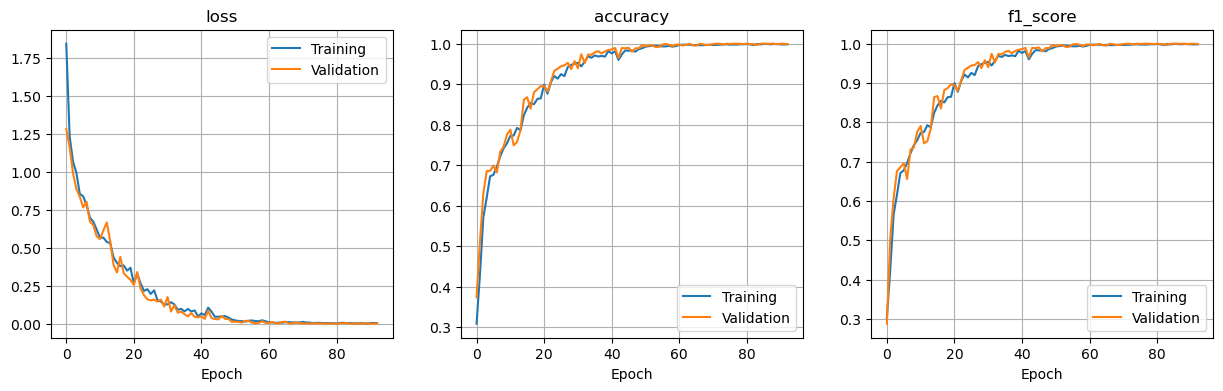

In [32]:
# plotting train history
plot_training_history(train_history)

In [33]:
best_model= get_parallel_vit()

best_model.load_weights(PATH_BEST_WEIGHT_SAVE)

In [34]:
# Use the best model for Test results: loss, accuracy, f1_score
test_loss = show_save_test_results(test_generator, best_model)

19/19 [==============================] - 26s 1s/step - loss: 0.0027 - accuracy: 0.9992 - f1_score: 0.9992


,model_name,test_loss,test_accuracy,test_f1_score
0,parallel_vit_dropout_changed,0.002687,0.999158,0.99923


In [35]:
# Get predictions from the model
predictions = best_model.predict(test_generator, verbose=1)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

true_labels_y_test =  np.array(test_generator.classes) # y_test
############################################################################################################]

19/19 [==============================] - 29s 1s/step


In [36]:
# # Classification report
store_classification_report(predicted_labels=predicted_labels, target_labels=true_labels_y_test)

,precision,recall,f1-score,support
0,0.997076,1.000000,0.998536,341.000000
1,1.000000,0.996269,0.998131,268.000000
2,1.000000,1.000000,1.000000,317.000000
3,1.000000,1.000000,1.000000,261.000000
accuracy,0.999158,0.999158,0.999158,0.999158
macro avg,0.999269,0.999067,0.999167,1187.000000
weighted avg,0.999160,0.999158,0.999157,1187.000000


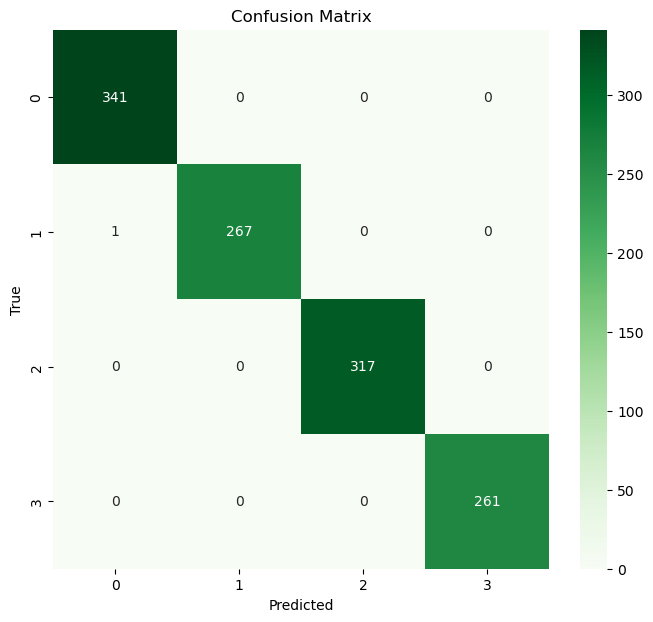

In [37]:
# For saving confusion matrix
show_save_confusion_matrix(predicted_labels=predicted_labels, target_labels=true_labels_y_test)

In [38]:
# # Calculate all
calculate_test_performance_metrics_all(predicted_labels=predicted_labels,
                                       target_labels=true_labels_y_test,
                                       test_loss=test_loss)

,Model Name,Accuracy,Macro Precision,Macro Recall,Macro F1-Score,Weighted Precision,Weighted Recall,Weighted F1-Score,Loss
0,parallel_vit_dropout_changed,0.999158,0.999269,0.999067,0.999167,0.99916,0.999158,0.999157,0.002687


In [39]:
data = calculate_TF_TP_FP_FN(true_labels_y_test, predicted_labels)
acc = calculate_accuracy(true_labels_y_test, predicted_labels)
calculate_metrics(class_to_performance_data=data, accuracy=acc)

,Metric Type,Value
0,overall accuracy,0.99916
1,Macro Precision,0.99927
2,Macro Recall,0.99907
3,Macro F1-Score,0.99917
4,Macro FPR,0.00030
5,Macro FNR,0.00093
6,Macro FDR,0.00073
7,Macro NPV,0.99973
8,Weighted Precision,0.99916
9,Weighted Recall,0.99916
